This notebook tries to search for optimal fixed policies (e.g. constant mortality) that maximize the objective (i.e. expected net reward). Here I try [scikit-optimize](https://scikit-optimize.github.io/stable/index.html).

# Setup
---

In [8]:
# %pip install -e ..
# %pip install scikit-optimize

In [29]:
import numpy as np
import pandas as pd
import ray

from skopt import gp_minimize, gbrt_minimize 
from skopt import dump
from skopt.plots import plot_objective, plot_convergence
from skopt.space import Real
from skopt.utils import use_named_args

from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor

from rl4fisheries import AsmEnv, Msy, ConstEsc, CautionaryRule
from rl4fisheries.envs.asm_fns import get_r_devs

In [3]:
CONFIG = {"s":  0.97}

## Hugging face login

In [4]:
## download & upload saved model weights
from huggingface_hub import hf_hub_download, HfApi, login
api = HfApi()
login()

# Policy Optimization
---

## Policy evaluation fn

In [22]:
@ray.remote
def generate_rew(policy, env_cls, config):
    ep_rew = 0
    env = env_cls(config=config)
    obs, info = env.reset()
    for t in range(env.Tmax):
        act, info = policy.predict(obs)
        obs, rew, term, trunc, info = env.step(act)
        ep_rew += rew
    return ep_rew


def rew_batch(policy, env_cls, config, batch_size):
    tmax = env_cls().Tmax
    parallel = [generate_rew.remote(policy, env_cls, config) for _ in range(batch_size)]
    rews = ray.get(parallel)
    
    return rews

def eval_pol(policy, env_cls, config, n_batches=4, batch_size=40, pb=False):
    batch_iter = range(n_batches)
    if pb:
        from tqdm import tqdm
        batch_iter = tqdm(iter)
    #
    rews = []
    for i in batch_iter:
        rews.append(
            rew_batch(policy=policy, env_cls=env_cls, config=config, batch_size=batch_size)
        )
    return np.array(rews).flatten()

## Objective fns

In [25]:
msy_space = [Real(0.001, 0.25, name='mortality')]
esc_space = [Real(0.001, 0.80, name='escapement')]
cr_space  = [
    Real(0.00001, 1, name='radius'),
    Real(0.00001, np.pi/4.00001, name='theta'),
    Real(0, 1, name='y2'),
]

@use_named_args(msy_space)
def msy_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    agent = Msy(env=eval_env, mortality = x['mortality'])
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, config=CONFIG, 
        n_batches=4, batch_size=40
    )
    return -np.mean(rews)

@use_named_args(esc_space)
def esc_obj(**x):
    eval_env = AsmEnv(config=CONFIG)
    agent = ConstEsc(env=eval_env, escapement = x['escapement'])
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, config=CONFIG, 
        n_batches=4, batch_size=40
    )
    return -np.mean(rews)

@use_named_args(cr_space)
def cr_obj(**x):
    theta = x["theta"]
    radius = x["radius"]
    x1 = np.sin(theta) * radius
    x2 = np.cos(theta) * radius
    #
    eval_env = AsmEnv(config=CONFIG)
    eval_env.reset()
    agent = CautionaryRule(env=eval_env, x1 = x1, x2 =  x2, y2 = x["y2"])
    rews = eval_pol(
        policy=agent, 
        env_cls=AsmEnv, 
        config=CONFIG, 
        n_batches=4, batch_size=40
    )
    return -np.mean(rews)  



## Optimization

### MSY

In [26]:
%%time
msy_gp = gp_minimize(msy_obj, msy_space, n_calls = 50, verbose=True, n_jobs=-1)
msy_gp.fun, msy_gp.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.0331
Function value obtained: -5.2814
Current minimum: -5.2814
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.9389
Function value obtained: -5.5732
Current minimum: -5.5732
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.9743
Function value obtained: -4.0990
Current minimum: -5.5732
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.9839
Function value obtained: -23.4898
Current minimum: -23.4898
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.9085
Function value obtained: -6.0686
Current minimum: -23.4898
Iteration No: 6 starte

(-255.9700683041442, [0.02342418282318141])

<Axes: >

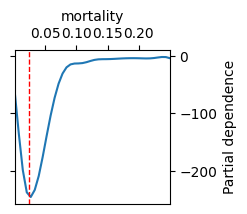

In [31]:
plot_objective(msy_gp)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

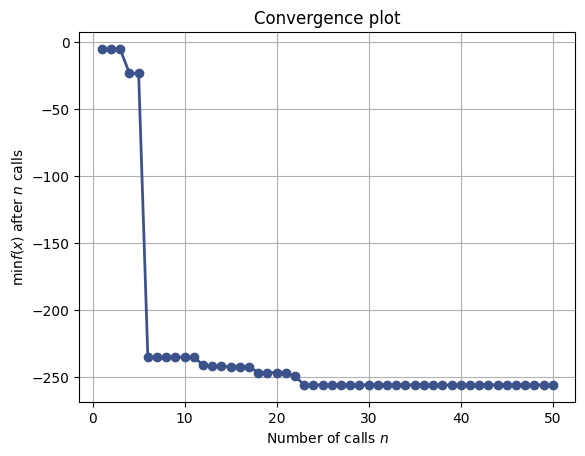

In [32]:
plot_convergence(msy_gp)

In [33]:
%%time
msy_gbrt = gbrt_minimize(msy_obj, msy_space, n_calls = 50, verbose=True, n_jobs=-1)
msy_gbrt.fun, msy_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.9771
Function value obtained: -26.3370
Current minimum: -26.3370
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.9244
Function value obtained: -91.3720
Current minimum: -91.3720
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.9164
Function value obtained: -4.1192
Current minimum: -91.3720
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.9492
Function value obtained: -144.8091
Current minimum: -144.8091
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.9418
Function value obtained: -5.0079
Current minimum: -144.8091
Iteration No: 

(-255.61248660708233, [0.02511500817922824])

<Axes: >

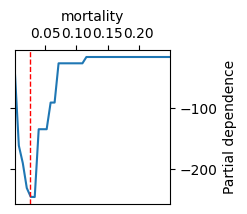

In [34]:
plot_objective(msy_gbrt)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

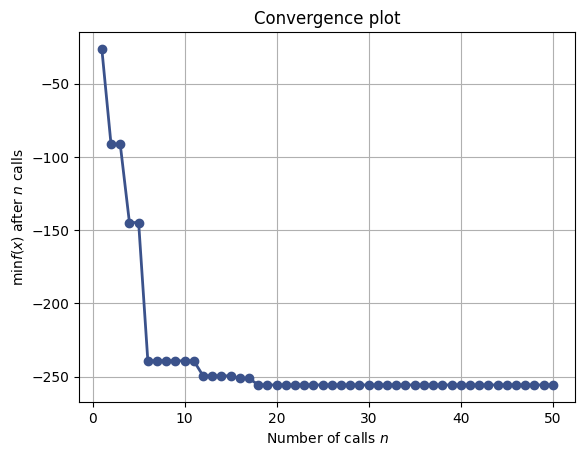

In [35]:
plot_convergence(msy_gbrt)

### Esc

In [36]:
%%time
esc_gp = gp_minimize(esc_obj, esc_space, n_calls = 50, verbose=True, n_jobs=-1)
esc_gp.fun, esc_gp.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.0844
Function value obtained: -26.2461
Current minimum: -26.2461
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8625
Function value obtained: -287.0738
Current minimum: -287.0738
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.9552
Function value obtained: -257.8897
Current minimum: -287.0738
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.9146
Function value obtained: -275.3590
Current minimum: -287.0738
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.8751
Function value obtained: -147.8621
Current minimum: -287.0738
Iterati

(-299.6823555974254, [0.16787857585865285])

<Axes: >

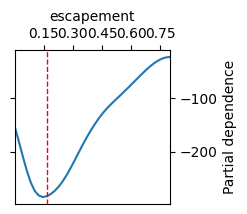

In [37]:
plot_objective(esc_gp)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

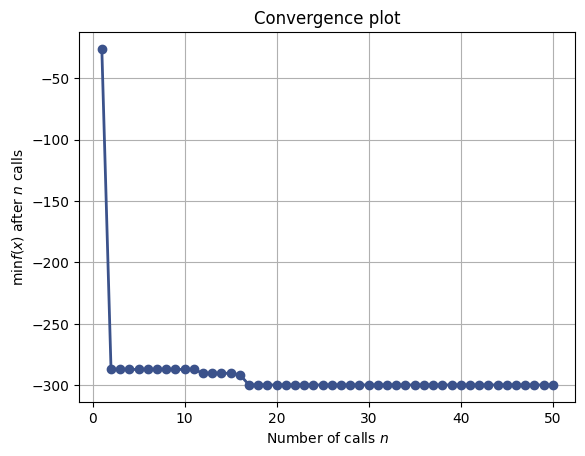

In [38]:
plot_convergence(esc_gp)

In [58]:
%%time
esc_gbrt = gbrt_minimize(esc_obj, esc_space, n_calls = 50, verbose=True, n_jobs=-1)
esc_gbrt.fun, esc_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.9597
Function value obtained: -48.4151
Current minimum: -48.4151
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.8968
Function value obtained: -240.4979
Current minimum: -240.4979
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.9159
Function value obtained: -28.7273
Current minimum: -240.4979
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8697
Function value obtained: -163.8213
Current minimum: -240.4979
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.8175
Function value obtained: -188.8821
Current minimum: -240.4979
Iteratio

(-292.9941660091451, [0.11305329406169397])

<Axes: >

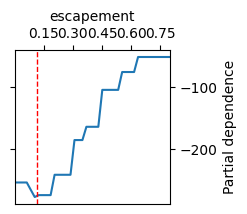

In [59]:
plot_objective(esc_gbrt)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

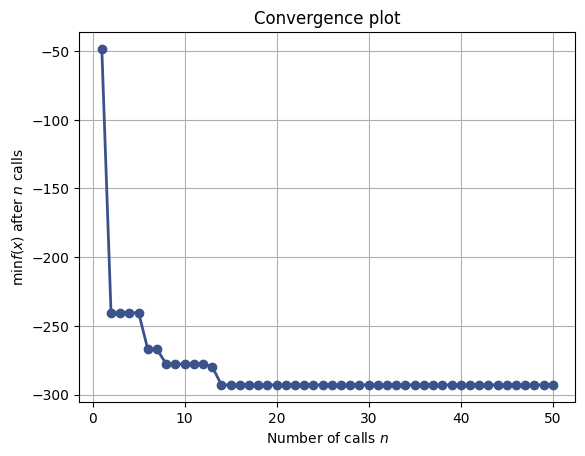

In [60]:
plot_convergence(esc_gbrt)

### CR

In [43]:
%%time
cr_gp = gp_minimize(cr_obj, cr_space, n_calls = 100, verbose=True, n_jobs=-1)
cr_gp.fun, cr_gp.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.9688
Function value obtained: -177.7430
Current minimum: -177.7430
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.9021
Function value obtained: -236.8874
Current minimum: -236.8874
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.8375
Function value obtained: -220.4030
Current minimum: -236.8874
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.8323
Function value obtained: -191.7080
Current minimum: -236.8874
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.7831
Function value obtained: -232.0564
Current minimum: -236.8874
Itera

(-311.0656367052435,
 [0.8260241432235854, 0.12728057019636857, 0.6172786457423112])

<Axes: >

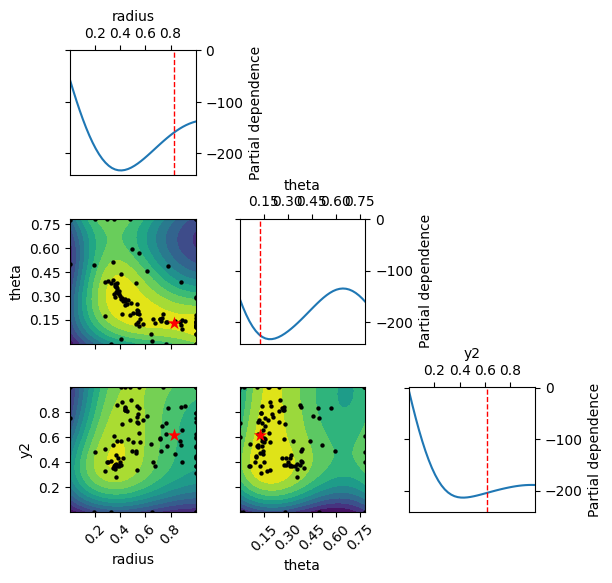

In [44]:
plot_objective(cr_gp)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

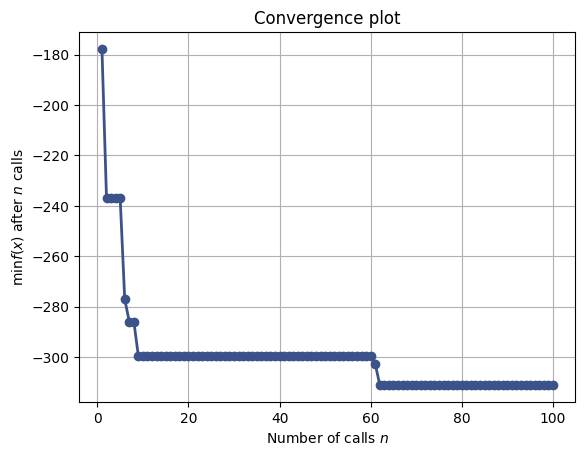

In [45]:
plot_convergence(cr_gp)

In [46]:
%%time
cr_gbrt = gp_minimize(cr_obj, cr_space, n_calls = 100, verbose=True, n_jobs=-1)
cr_gbrt.fun, cr_gbrt.x

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.0046
Function value obtained: -290.4467
Current minimum: -290.4467
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.9040
Function value obtained: -287.7544
Current minimum: -290.4467
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.8965
Function value obtained: -249.5194
Current minimum: -290.4467
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.9173
Function value obtained: -270.6394
Current minimum: -290.4467
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.8864
Function value obtained: -65.5867
Current minimum: -290.4467
Iterat

(-308.53680147877856,
 [0.23674914103361688, 0.4274663412150027, 0.10944474970918672])

<Axes: >

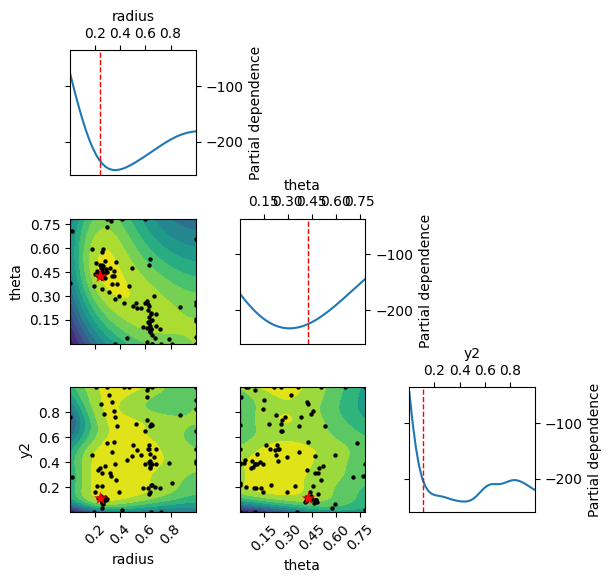

In [47]:
plot_objective(cr_gbrt)

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

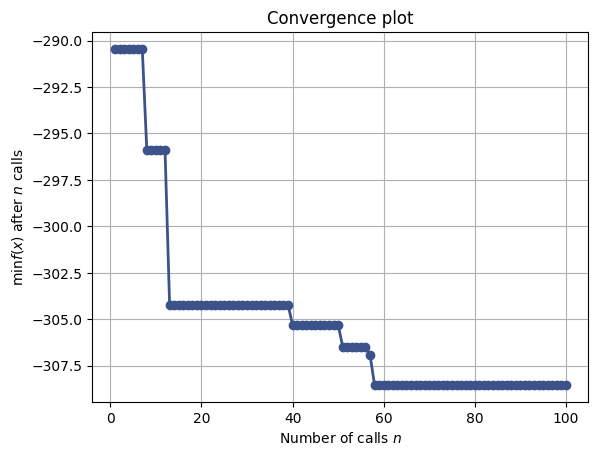

In [48]:
plot_convergence(cr_gbrt)

# Saving results

### MSY

In [51]:
path = "../saved_agents/"
fname = "msy_gp.pkl"
dump(msy_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

path = "../saved_agents/"
fname = "msy_gbrt.pkl"
dump(msy_gbrt, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

CommitInfo(commit_url='https://huggingface.co/boettiger-lab/rl4eco/commit/93a77a99bc7c9d63f939b187be8953839673c1f4', commit_message='Upload sb3/rl4fisheries/msy_gbrt.pkl with huggingface_hub', commit_description='', oid='93a77a99bc7c9d63f939b187be8953839673c1f4', pr_url=None, pr_revision=None, pr_num=None)

### Esc

In [52]:
path = "../saved_agents/"
fname = "esc_gp.pkl"
dump(esc_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

path = "../saved_agents/"
fname = "esc_gbrt.pkl"
dump(msy_gbrt, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

CommitInfo(commit_url='https://huggingface.co/boettiger-lab/rl4eco/commit/6d5916a6c8a127c0fad05c60939599a5433977f3', commit_message='Upload sb3/rl4fisheries/esc_gbrt.pkl with huggingface_hub', commit_description='', oid='6d5916a6c8a127c0fad05c60939599a5433977f3', pr_url=None, pr_revision=None, pr_num=None)

### CR

In [53]:
path = "../saved_agents/"
fname = "cr_gp.pkl"
dump(cr_gp, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

path = "../saved_agents/"
fname = "cr_gbrt.pkl"
dump(cr_gbrt, path+fname)

api.upload_file(
    path_or_fileobj=path+fname,
    path_in_repo="sb3/rl4fisheries/"+fname,
    repo_id="boettiger-lab/rl4eco",
    repo_type="model",
)

cr_gp.pkl:   0%|          | 0.00/5.96M [00:00<?, ?B/s]

cr_gbrt.pkl:   0%|          | 0.00/5.96M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/boettiger-lab/rl4eco/commit/27377b295b025a82b77e1010c4ec40e0530a7ac5', commit_message='Upload sb3/rl4fisheries/cr_gbrt.pkl with huggingface_hub', commit_description='', oid='27377b295b025a82b77e1010c4ec40e0530a7ac5', pr_url=None, pr_revision=None, pr_num=None)

# Cross evaluate

In [56]:
cr_gbrt.x

[0.23674914103361688, 0.4274663412150027, 0.10944474970918672]

In [61]:
pol_env = AsmEnv(config=CONFIG)

msy_rews = eval_pol(
    policy=Msy(env=pol_env, mortality=msy_gbrt.x[0]), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=4, batch_size=40
)

esc_rews = eval_pol(
    policy=ConstEsc(env=pol_env, escapement=esc_gbrt.x[0]), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=4, batch_size=40
)

radius, theta, y2 = cr_gbrt.x
x1 = np.sin(theta) * radius
x2 = np.cos(theta) * radius

cr_rews = eval_pol(
    policy=CautionaryRule(env=pol_env, x1=x1, x2=x2, y2=y2), 
    env_cls=AsmEnv, config=CONFIG, 
    n_batches=4, batch_size=40
)

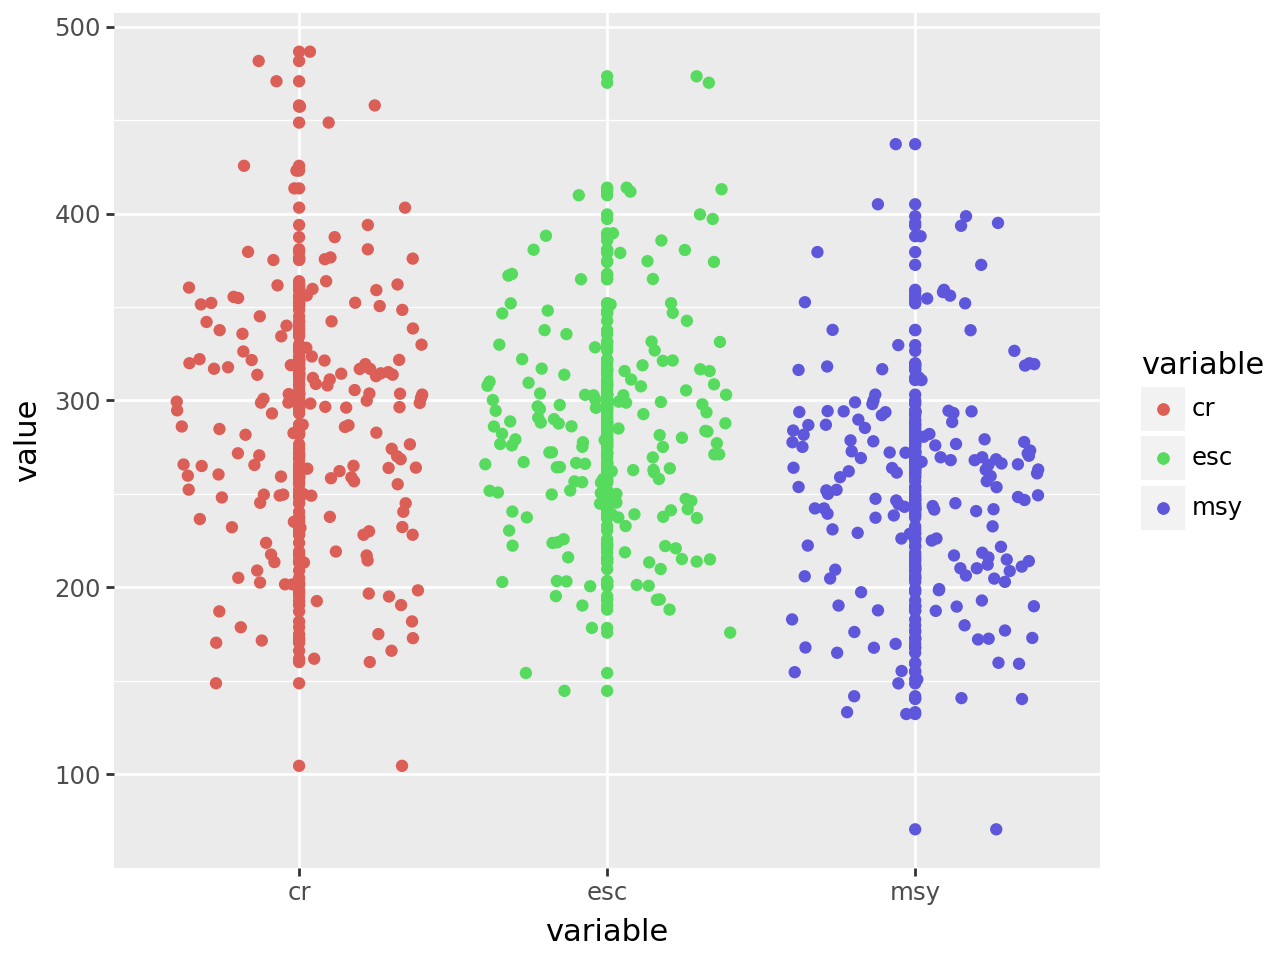

In [62]:
from plotnine import ggplot, aes, geom_point, geom_jitter

df = pd.DataFrame({
    'msy': msy_rews,
    'esc': esc_rews,
    'cr': cr_rews,
}).melt()

ggplot(df, aes(x='variable', y='value', color='variable')) + geom_point() + geom_jitter()